In [1]:
print('Importing packages...')

import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.layers import Merge
from keras.layers import TimeDistributed, Lambda
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers.advanced_activations import PReLU
from keras.preprocessing import sequence, text

import h5py # Used to save models

Importing packages...


Using TensorFlow backend.


In [2]:
print('Reading Data...')

# Output directory
train_loc = 'local' # floyd or local
num_epochs = 1  # Originally used 200

if train_loc == 'floyd':
    output = '../output/'
    data_loc = '../data/'
else:
    output = '../output_conv/'
    data_loc = '../data/'

# Import data
csv_train = data_loc + 'train.csv'
data = pd.read_csv(csv_train)
y = data.is_duplicate.values


# Tokenize text

num_words = 200000  # The total number of word to incorperates in the search
max_len = 40 # The maximum length of a sequence

######################################################
# When training in one go use below
######################################################
# tk = text.Tokenizer(num_words=num_words)  # Create a tokenizer object

# tk.fit_on_texts(list(data.question1.values) +
#                 list(data.question2.values.astype(str)))
######################################################
# When using tokenizer made earlier, use below
######################################################
try:
    import cPickle as pickle # If in python 2 environment
except:
    import pickle # If in a pythnon 3 environment

tk = pickle.load(open('../data/tokenizer.p','rb'))

word_index = tk.word_index
######################################################

x1 = tk.texts_to_sequences(data.question1.values)
x1 = sequence.pad_sequences(x1,maxlen=max_len)

x2 = tk.texts_to_sequences(data.question2.values.astype(str))
x2 = sequence.pad_sequences(x2,maxlen=max_len)

ytrain_enc = np_utils.to_categorical(y)

Reading Data...


In [3]:
print('Generating embeddings...')

embeddings_index = {}
f = open(data_loc + 'glove.840B.300d.txt')
unfound = []
unfound_vals = []
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        unfound.append(word)
        unfound_vals.append(values[1:])
f.close()

print('Found %s word vectors.' % len(embeddings_index))

print('Creating embedding matrix...')

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


max_features = 200000
filter_length = 5
nb_filter = 64
pool_length = 4

1931it [00:00, 19305.55it/s]

Generating embeddings...


2196017it [01:48, 20249.74it/s]
  8%|▊         | 7442/95603 [00:00<00:01, 74415.64it/s]

Found 2196016 word vectors.
Creating embedding matrix...


100%|██████████| 95603/95603 [00:00<00:00, 102991.64it/s]


In [31]:
print('Build model...')

# Question 1 - Embeddings -> Convolutional

model3 = Sequential()
model3.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=40,
                     trainable=False))
model3.add(Convolution1D(nb_filter=nb_filter,
                         filter_length=filter_length,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))

model3.add(GlobalMaxPooling1D())

# Question 2 - Embeddings -> Convolutional

model4 = Sequential()
model4.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=40,
                     trainable=False))
model4.add(Convolution1D(nb_filter=nb_filter,
                         filter_length=filter_length,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))

model4.add(GlobalMaxPooling1D())

# Merge Questions

merged_model = Sequential()
merged_model.add(Merge([model3, model4], mode='concat'))
merged_model.add(BatchNormalization())

merged_model.add(Dense(1))
merged_model.add(Activation('sigmoid'))

Build model...


/Users/dattlee/miniconda/envs/quora_question_pairs/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="valid", strides=1, filters=64, kernel_size=5)`
  from ipykernel import kernelapp as app
/Users/dattlee/miniconda/envs/quora_question_pairs/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="valid", strides=1, filters=64, kernel_size=5)`
/Users/dattlee/miniconda/envs/quora_question_pairs/lib/python2.7/site-packages/ipykernel_launcher.py:38: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [32]:
# Loss, Optimizer, Accuracy
from keras.optimizers import Adam

adam = Adam()

merged_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

batch_size = 384
# Save checkpoints
checkpoint = ModelCheckpoint(output+'weights.h5', monitor='val_acc', save_best_only=True, verbose=2)

from keras.callbacks import TensorBoard

checkpoint_board = TensorBoard(log_dir=output+'/logs/',batch_size=batch_size,write_graph=True)

from keras.callbacks import EarlyStopping

max_epoch_wait = 4
checkpoint_early = EarlyStopping(monitor='val_acc',patience=max_epoch_wait) # Mode is inferred by acc

In [33]:
# Train Model

# Train model on x1 and x2
history = merged_model.fit([x1, x2], y=y, batch_size=batch_size, epochs=num_epochs,
                 verbose=1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,checkpoint_board,checkpoint_early]) # Add tensorboard in callbacks list

Train on 363861 samples, validate on 40429 samples
Epoch 1/1
363861/363861 [==============================] - 215s - loss: 0.5289 - acc: 0.7396 - val_loss: 0.4891 - val_acc: 0.7659


In [30]:
pickle.dump(history.history,open(output + 'history.p','wb'))

['acc', 'loss', 'val_acc', 'val_loss']


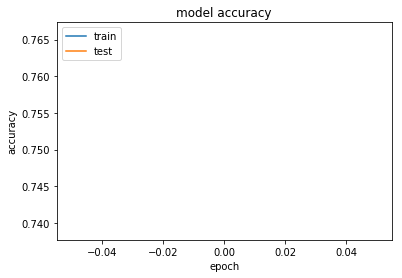

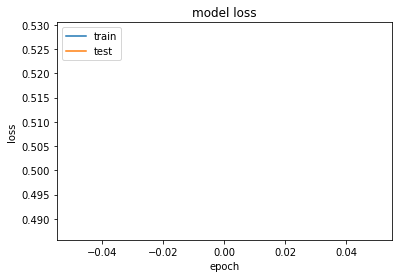

In [22]:
#Use below to plot details of models run

# import matplotlib.pyplot as plt

# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [25]:
print(history.history['history'])

KeyError: 'history'

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
# Save Model

# serialize model to JSON
model_json = merged_model.to_json()
with open(output + "model.json", "w") as json_file:
    json_file.write(model_json)

In [8]:
# Make predictions on submission data

# Import test datax
csv_test = data_loc + 'test.csv'
test_data = pd.read_csv(csv_test)

t_x1 = tk.texts_to_sequences(test_data.question1.values.astype(str))
t_x1 = sequence.pad_sequences(t_x1,maxlen=max_len)

t_x2 = tk.texts_to_sequences(test_data.question2.values.astype(str))
t_x2 = sequence.pad_sequences(t_x2,maxlen=max_len)

p_test = merged_model.predict([t_x1,t_x2],batch_size=100,verbose=1)

# Predict
df_test = pd.read_csv(data_loc+'test.csv')

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv(output + 'predictions.csv', index=False)

2345700/2345796 [============================>.] - ETA: 0s